<a href="https://colab.research.google.com/github/Aseward1005/3560P10-11/blob/main/CS4650_Big_Data_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors: Anthony Seward, Nicholas Baron, Sunjay Guttikonda

The idea of our project is to take a dataset describing Player Unknown's Battleground (PUBG) matches and use that data to see if we can maybe predict who is most likely to win based on the stats, as well as gain some insight into what stats are the most important in the game.

Data set source: https://www.kaggle.com/competitions/pubg-finish-placement-prediction/data

Since the target value (`winPlacePerc` in the dataset) ranges from 0 to 1, we will use a linear regressor.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# All of the imports
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn import linear_model, datasets, preprocessing
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.utils.data as data_utils

In [ ]:
def read_data(csv_name: str):
    zip_name = ''.join(['drive/MyDrive/pubg_data/', csv_name, '.zip'])
    with ZipFile(zip_name) as data:
        with data.open(csv_name) as csv:
            return pd.read_csv(csv)

train_data = read_data('train_V2.csv')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

The dataset has ~4 million rows and 29 columns.

Some columns have additional logic which makes them unsuitable for a linear regression.
`killPoints`, `rankPoints`, and `winPoints` have special logic regarding -1 in addition to `rankPoints` being deprecated.
Furthermore, `matchType` is a finite set of non-numeric values, which may not play nicely with the regressor.
The columns ending in `Id` will also need to be removed both because they are non-numeric (according to Pandas) and because we are looking for win placements regardless of match, group, or specific player.
In total, 7 columns need to be removed, leaving 22 for the regressor.

In [ ]:
train_data_cleaned = train_data.drop(['Id', 'groupId', 'matchId', 'rankPoints', 'killPoints', 'winPoints', 'matchType'], axis = 1)
train_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 22 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int64  
 1   boosts           int64  
 2   damageDealt      float64
 3   DBNOs            int64  
 4   headshotKills    int64  
 5   heals            int64  
 6   killPlace        int64  
 7   kills            int64  
 8   killStreaks      int64  
 9   longestKill      float64
 10  matchDuration    int64  
 11  maxPlace         int64  
 12  numGroups        int64  
 13  revives          int64  
 14  rideDistance     float64
 15  roadKills        int64  
 16  swimDistance     float64
 17  teamKills        int64  
 18  vehicleDestroys  int64  
 19  walkDistance     float64
 20  weaponsAcquired  int64  
 21  winPlacePerc     float64
dtypes: float64(6), int64(16)
memory usage: 746.4 MB


In [ ]:
train_data_cleaned.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,...,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,9.247833e-01,5.439551e-01,2.299759e+01,...,4.300759e+01,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,1.558445e+00,7.109721e-01,5.097262e+01,...,2.328949e+01,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,2.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,3.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.000000e+00,1.000000e+00,2.132000e+01,...,4.700000e+01,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,7.200000e+01,2.000000e+01,1.094000e+03,...,1.000000e+02,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,1.000000e+00


## Notes on Histograms
The duration histogram has 3 spikes: one just before 1000 seconds, one just before 1500, and one before 2000.
Most histograms have negative trends, which coorelates with skill in that particular statistic.
The drop in `killPlace` means that ranks 90 to 100 often do not have any kills.

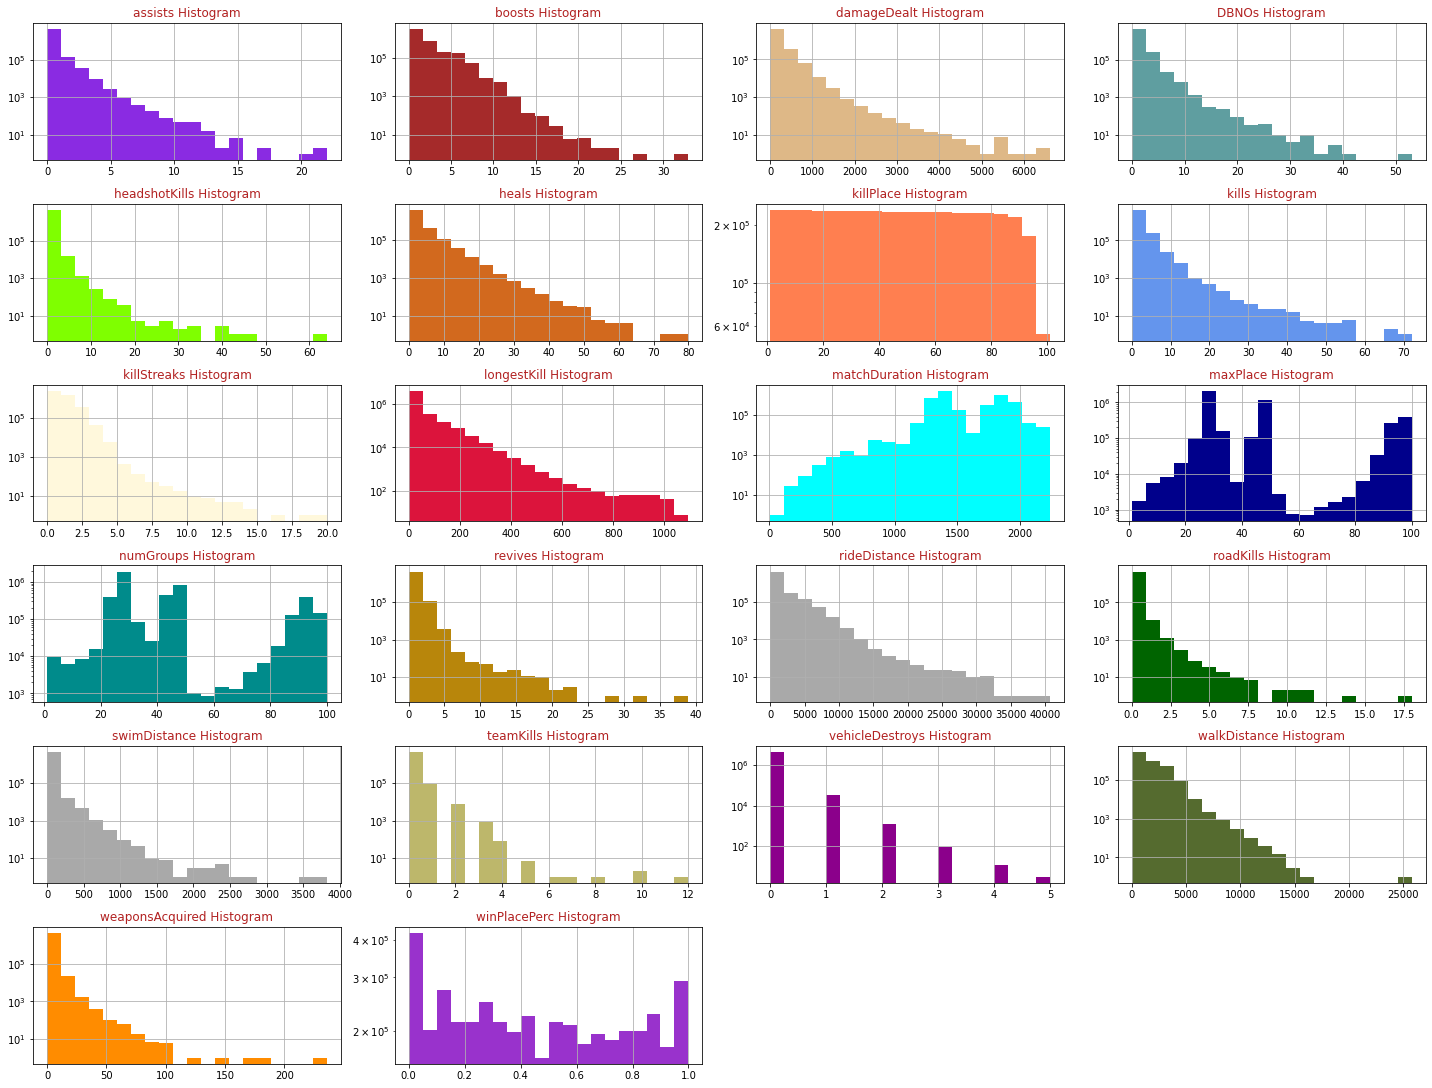

In [ ]:
#histogram because 72 kills is REALLY high (from a player of the game)
#show histograms for overall data
colors = list(mcolors.CSS4_COLORS.keys())[10:]
fig = plt.figure(figsize=(20,20))
for i, feature in enumerate(train_data_cleaned.columns):
    f = fig.add_subplot(8, 4, i + 1)
    train_data_cleaned[feature].hist(bins = 20, ax = f, facecolor = colors[i])
    f.set_title(feature + " Histogram", color = colors[35])
    f.set_yscale('log')
fig.tight_layout()
plt.show()

Input contains NaN, infinity, or value too large for float64, meaning this is a float64, this can be in either damageDealt, longestKill, rideDistance, swimDistance, or winPlacePerc. It doesn't say which one, meaning we have to do some testing to find it

for some reason 2744604 is null, we will remove that row from the data

In [ ]:
#split x and y train set
y_train = train_data_cleaned['winPlacePerc']
x_train = train_data_cleaned.iloc[:, train_data_cleaned.columns != 'winPlacePerc']

In [ ]:
print(x_train['damageDealt'].isnull().values.any())
print(x_train['longestKill'].isnull().values.any())
print(x_train['rideDistance'].isnull().values.any())
print(x_train['swimDistance'].isnull().values.any())
print(y_train.isnull().values.any())
print([i for i, val in enumerate(y_train.isnull().values) if val])
print(y_train[2744604])

False
False
False
False
False
[]


KeyError: ignored

In [ ]:
train_data_cleaned.drop(index = 2744604, axis = 0, inplace = True)

In [ ]:
#split x and y train set
y_train = train_data_cleaned['winPlacePerc']
x_train = train_data_cleaned.iloc[:, train_data_cleaned.columns != 'winPlacePerc']

In [ ]:
#create the model
model = linear_model.LinearRegression()
model.fit(x_train,y_train)
yhat = model.predict(x_train)

#output the mean square error
print(f'Mean-square error: {np.sqrt(mean_squared_error(yhat, y_train)):.2f}')
print(f'Score: {model.score(x_train, y_train)}')

Mean-square error: 0.13
Score: 0.8295834124511875


In [ ]:
model.coef_

array([ 1.45605002e-02,  1.44684449e-02,  5.82494660e-05, -4.70786724e-03,
        1.84470759e-03,  7.15778725e-04, -7.03493212e-03, -1.51448047e-02,
       -1.34830073e-01,  9.48757316e-06, -1.60688179e-04, -7.47157796e-03,
        8.87797736e-03,  1.41222304e-02,  1.80900751e-05,  1.46760143e-02,
        1.09811205e-04, -1.49135885e-02,  9.45218772e-03,  1.14967742e-04,
        1.12535271e-02])

Most of the coefficients seem small, so normalizing the input data may help find which features are less important.

In [ ]:
scalar = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scalar.transform(x_train)

scaled_model = linear_model.LinearRegression()
scaled_model.fit(x_train_scaled, y_train)
yhat = scaled_model.predict(x_train_scaled)

print(f'Mean-square error: {np.sqrt(mean_squared_error(yhat, y_train)):.2f}')
print(f'Score: {scaled_model.score(x_train_scaled, y_train)}')

Mean-square error: 0.13
Score: 0.8295834124511876


In [ ]:
scaled_model.coef_

array([ 0.00856992,  0.02482487,  0.00994788, -0.005394  ,  0.0011108 ,
        0.00191827, -0.19319984, -0.02360234, -0.09586041,  0.00048361,
       -0.04157626, -0.17803348,  0.20676353,  0.00666805,  0.02710515,
        0.00107682,  0.00334948, -0.00249644,  0.00087538,  0.13606397,
        0.02764477])

Scaled Lasso Model

In [ ]:
scaled_lasso = linear_model.Lasso(alpha = .3)
scaled_lasso.fit(x_train_scaled, y_train)
yhat = scaled_lasso.predict(x_train_scaled)

print(f'Mean-square error: {np.sqrt(mean_squared_error(yhat, y_train)):.2f}')
print(f'Score: {scaled_model.score(x_train_scaled, y_train)}')

Mean-square error: 0.31
Score: 0.8295834124511876


In [ ]:
scaled_lasso.coef_

array([ 0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
scaled_lasso.intercept_

0.4728215527219128

The regressor in this way always guesses 47th place. It places a straight line on the mean and says "no point trying to rationalize, just guess 47 and you will be right 82.9% of the time"

Looks like an underfitting problem.

There are a couple options from here, we can do some sampling. Maybe the dataset is just too large with too many 47's, and splitting the dataset into smaller samples will allow the regressor to pick up on more data. We can then do something like a random forest and combine the regressors from the smaller datasets.

We can average all the data from the same datapoints and massively shrink our dataset

We can try a different type of classifier (neural nets are fun)
(actually do a polynomial model, not neural net yet)

Or maybe it really doesn't matter and pubg is just too random of a game (I don't like this answer)

We probably should try to work back in the ranking data though.

## First we try to include rankings

Logic: if there is a -1 in rankPoints, it is counted as a none, we remove those.
Then if there is a 0 in winPoints or killPoints, those are also counted as none, we remove those.
Then the dataset says that rankPoints is inconsistent. We thus remove that column (but maybe the inconsistency is offset by how large the dataset is? it's worth testing.)

In [ ]:
train_data_cleaned2 = train_data[train_data['rankPoints'] != -1]
train_data_cleaned2 = train_data_cleaned2[train_data_cleaned2['winPoints'] != 0]
train_data_cleaned2 = train_data_cleaned2[train_data_cleaned2['killPoints'] != 0]
train_data_cleaned2.drop(['Id', 'groupId', 'matchId', 'matchType'], axis = 1, inplace = True)

#train_data_cleaned2.drop(index = 2744604, axis = 0, inplace = True) #remove the dumb dumb that messed us up earlier
# that datapoint actually didn't have rankpoints or winpoints or killpoints so it doesn't matter

train_data_cleaned2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89509 entries, 19 to 4446935
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   assists          89509 non-null  int64  
 1   boosts           89509 non-null  int64  
 2   damageDealt      89509 non-null  float64
 3   DBNOs            89509 non-null  int64  
 4   headshotKills    89509 non-null  int64  
 5   heals            89509 non-null  int64  
 6   killPlace        89509 non-null  int64  
 7   killPoints       89509 non-null  int64  
 8   kills            89509 non-null  int64  
 9   killStreaks      89509 non-null  int64  
 10  longestKill      89509 non-null  float64
 11  matchDuration    89509 non-null  int64  
 12  maxPlace         89509 non-null  int64  
 13  numGroups        89509 non-null  int64  
 14  rankPoints       89509 non-null  int64  
 15  revives          89509 non-null  int64  
 16  rideDistance     89509 non-null  float64
 17  roadKills

This took the dataset down from 4 mill to 90000.

Hopefully there is no more underfitting, as we removed a bunch of datapoints AND added features to the dataset

In [ ]:
#split x and y train set
y_train = train_data_cleaned2['winPlacePerc']
x_train = train_data_cleaned2.iloc[:, train_data_cleaned2.columns != 'winPlacePerc']

In [ ]:
#create the model
model = linear_model.LinearRegression()
model.fit(x_train,y_train)
yhat = model.predict(x_train)

#output the mean square error
print(f'Mean-square error: {np.sqrt(mean_squared_error(yhat, y_train)):.2f}')
print(f'Score: {model.score(x_train, y_train)}')

Mean-square error: 0.12
Score: 0.8490990348058034


The score is 2 percent better, I'll take it, but also maybe the score is better because we have a smaller dataset

In [ ]:
model.coef_

array([ 1.25419185e-02,  1.42639013e-02,  6.41991371e-05, -1.80816911e-04,
        1.44938659e-03,  1.12045062e-03, -7.10586924e-03, -6.07562396e-05,
       -1.71090376e-02, -1.37705941e-01, -1.69356988e-06, -1.83091555e-04,
       -4.51098834e-03,  5.81433528e-03,  3.55618313e-17,  1.62038606e-02,
        1.66270909e-05, -1.06753377e-02,  9.06695228e-05, -3.00658121e-02,
        1.33936264e-02,  1.16190373e-04,  1.17053512e-02,  2.18714543e-04])

The coefficients are still very low, so LASSO will probably still scale this all down to 0

In [ ]:
scalar = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scalar.transform(x_train)

scaled_model = linear_model.LinearRegression()
scaled_model.fit(x_train_scaled, y_train)
yhat = scaled_model.predict(x_train_scaled)

print(f'Mean-square error: {np.sqrt(mean_squared_error(yhat, y_train)):.2f}')
print(f'Score: {scaled_model.score(x_train_scaled, y_train)}')


Mean-square error: 0.12
Score: 0.8490990348058034


In [ ]:
scaled_lasso = linear_model.Lasso(alpha = .3)
scaled_lasso.fit(x_train_scaled, y_train)
yhat = scaled_lasso.predict(x_train_scaled)

print(f'Mean-square error: {np.sqrt(mean_squared_error(yhat, y_train)):.2f}')
print(f'Score: {scaled_model.score(x_train_scaled, y_train)}')

Mean-square error: 0.31
Score: 0.8490990348058034


In [ ]:
scaled_lasso.coef_

array([ 0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
scaled_lasso.intercept_

0.47047983778167557

It says rankPoints is being deprecated, so we now remove that and see if the regressor performs any better (we are still underfitting, so I suspect it won't change much)

In [ ]:
train_data_cleaned3 = train_data_cleaned2.drop('rankPoints', axis = 1)

In [ ]:
#split x and y train set
y_train = train_data_cleaned3['winPlacePerc']
x_train = train_data_cleaned3.iloc[:, train_data_cleaned3.columns != 'winPlacePerc']

In [ ]:
#create the model
model = linear_model.LinearRegression()
model.fit(x_train,y_train)
yhat = model.predict(x_train)

#output the mean square error
print(f'Mean-square error: {np.sqrt(mean_squared_error(yhat, y_train)):.2f}')
print(f'Score: {model.score(x_train, y_train)}')

Mean-square error: 0.12
Score: 0.8490990348058034


As expected, this didn't really do much. We're gonna need a more complicated model

In [ ]:
#start with linear connection, and reLU all the way through
class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(24, 48).to(torch.float64)

    self.linear2 = nn.Linear(48, 24).to(torch.float64)

    self.linear3 = nn.Linear(24, 12).to(torch.float64)

    self.linear4 = nn.Linear(12, 6).to(torch.float64)
    self.out = nn.Linear(6, 1).to(torch.float64)

    #activation function is constant
    self.act = nn.ReLU()

  def forward(self, x):
    hidden1 = self.linear1(x)
    hidden1 = self.act(hidden1)

    hidden2 = self.linear2(hidden1)
    hidden2 = self.act(hidden2)

    hidden3 = self.linear3(hidden2)
    hidden3 = self.act(hidden3)

    hidden4 = self.linear4(hidden3)
    hidden4 = self.act(hidden4)

    out = self.out(hidden4)
    return self.act(out)

In [ ]:
def train_regressor(opt, model, loader, epochs = 5):
  #loss function definition
  loss_fn = nn.MSELoss()

  for i in range(epochs):
    print(f'epoch{i}')
    #train the model on the minibatch
    for inputs, targets in loader:
      #zero the gradient
      opt.zero_grad()

      #calculate predictions for given x
      x_pred = model(inputs)
      #calculate loss vs given y
      loss = loss_fn(x_pred, targets)
      #calculate the gradient
      loss.backward()

      #print the loss
      print(loss)

      #perform an optimizer step
      opt.step()

In [ ]:
#im not gonna lie, chatgpt is a godsend
class tensorSet(data_utils.Dataset):
  def __init__(self, data, targets):
    # Store the data and targets
    self.data = data.to_numpy()
    self.data = torch.from_numpy(self.data)

    self.targets = targets.to_numpy()
    self.targets = torch.from_numpy(self.targets)

  def __len__(self):
    # Return the length of the dataset
    return len(self.data)

  def __getitem__(self, index):
    # Get the data point and target at the given index
    data_point = self.data[index]
    target = self.targets[index]

    return data_point, target

im running into issues and running out of patience, I'm just gonna hardcode the parameters

In [ ]:
len(x_train.columns)

24

In [ ]:
regressor = Regressor()
optimizer = torch.optim.Adam(regressor.parameters(), lr = .0001)

dataset = tensorSet(x_train, y_train)

dataloader = data_utils.DataLoader(dataset, batch_size=64, shuffle=True)

train_regressor(optimizer, regressor, dataloader)

In [ ]:
ypred = regressor(torch.from_numpy(x_train.to_numpy()))
ypred = torch.clamp(ypred, 0, 1)

print(np.sqrt(mean_squared_error(torch.from_numpy(y_train.to_numpy(y_train)).detach().numpy(), ypred.detach().numpy())))
print(r2_score(torch.from_numpy(y_train.to_numpy()).detach().numpy(), ypred.detach().numpy()))

NameError: ignored

the model is performing extremely poorly, not only that, it somehow performs BETTER when it isn't clamped. What? (we updated the model to add more neurons in the hidden layers and now it more accurately represents the dataset)

# Test Data

## Test data preprocessing

we used dataset 2, so the preprocessing should be the same

In [ ]:
test_data = read_data('test_V2.csv')

In [ ]:
test_data_cleaned2 = test_data[test_data['rankPoints'] != -1]
test_data_cleaned2 = test_data_cleaned2[test_data_cleaned2['winPoints'] != 0]
test_data_cleaned2 = test_data_cleaned2[test_data_cleaned2['killPoints'] != 0]
test_data_cleaned2.drop(['Id', 'groupId', 'matchId', 'matchType'], axis = 1, inplace = True)

test_data_cleaned2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41429 entries, 37 to 1934073
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   assists          41429 non-null  int64  
 1   boosts           41429 non-null  int64  
 2   damageDealt      41429 non-null  float64
 3   DBNOs            41429 non-null  int64  
 4   headshotKills    41429 non-null  int64  
 5   heals            41429 non-null  int64  
 6   killPlace        41429 non-null  int64  
 7   killPoints       41429 non-null  int64  
 8   kills            41429 non-null  int64  
 9   killStreaks      41429 non-null  int64  
 10  longestKill      41429 non-null  float64
 11  matchDuration    41429 non-null  int64  
 12  maxPlace         41429 non-null  int64  
 13  numGroups        41429 non-null  int64  
 14  rankPoints       41429 non-null  int64  
 15  revives          41429 non-null  int64  
 16  rideDistance     41429 non-null  float64
 17  roadKills

In [ ]:
#y_test = test_data_cleaned2['winPlacePerc'], the "test" dataset doesn't actually have the values built in because this is a competition, so we can predict, but we won't know how good our predictions are
x_test = test_data_cleaned2.iloc[:, test_data_cleaned2.columns != 'winPlacePerc']

## Test Data predictions

In [ ]:
_ypred = regressor(torch.from_numpy(x_test.to_numpy()))
ypred = torch.clamp(ypred, 0, 1)

I can print/visualize this but there is no way to actually check if my predictions are good. I need to actually do a train/test split on the original dataset

## Train/Test Split

In [ ]:
#split x and y train set
y_train = train_data_cleaned2['winPlacePerc']
x_train = train_data_cleaned2.iloc[:, train_data_cleaned2.columns != 'winPlacePerc']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
#build and train the regressor on the training data
regressor = Regressor()
optimizer = torch.optim.Adam(regressor.parameters(), lr = .0001)

dataset = tensorSet(x_train, y_train)

dataloader = data_utils.DataLoader(dataset, batch_size=64, shuffle=True)

train_regressor(optimizer, regressor, dataloader)

#test the regressor on the training data
ypred = regressor(torch.from_numpy(x_train.to_numpy()))
ypred = torch.clamp(ypred, 0, 1)
print(np.sqrt(mean_squared_error(ypred.detach().numpy(), torch.from_numpy(y_train.to_numpy(y_train)).detach().numpy())))
print(r2_score(torch.from_numpy(y_train.to_numpy()).detach().numpy(), ypred.detach().numpy()))

epoch0
tensor(8.1204, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(5.8179, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(3.7114, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.4334, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(5.6352, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(2.6292, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.2677, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(3.4077, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(6.0478, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(3.2541, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(6.5498, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(3.4389, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(2.1648, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(4.6509, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(3.4560, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.6265, dtype=torch.float6

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.4170, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3298, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3853, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3081, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.2958, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.2896, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3394, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3560, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.2969, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.2827, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.2947, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3125, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3296, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3121, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3105, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3101, dtype=torch.float64, grad

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.2959, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3290, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3577, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3613, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.2942, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3352, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.2948, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.2748, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.2960, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3092, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.2906, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3452, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3276, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.2833, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3247, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3242, dtype=torch.float64, grad

observations

In [ ]:
#test the regressor on the testing data
ypred = regressor(torch.from_numpy(x_test.to_numpy()))
ypred = torch.clamp(ypred, 0, 1)
print(np.sqrt(mean_squared_error(torch.from_numpy(y_test.to_numpy(y_train)).detach().numpy(), ypred.detach().numpy())))
print(r2_score(torch.from_numpy(y_test.to_numpy()).detach().numpy(), ypred.detach().numpy()))

0.31440922283508166
-0.05148603661409079


Observations: DID WE OVERFIT? NO, WE DID NOT OVERFIT

The MLP is about as good as just guessing a straight line, the parameters likely aren't correctly tuned, but the linear model beats it by a lot.

This leads to the conclusion that maybe there really is a linear relationship between the attributes and the final placement, even though the coefficients are low. The linear model will be run again below on the new test/train split

In [ ]:
#create the linear regression model
model = linear_model.LinearRegression()
model.fit(x_train,y_train)
yhat = model.predict(x_train)

#output the mean square error
print(f'Mean-square error: {np.sqrt(mean_squared_error(yhat, y_train)):.2f}')
print(f'Score: {model.score(x_train, y_train)}') #score is the r2 value

Mean-square error: 0.12
Score: 0.8496849222318815


In [ ]:
#run it on the test set
yhat = model.predict(x_test)

#output the mean square error
print(f'Mean-square error: {np.sqrt(mean_squared_error(yhat, y_test)):.2f}')
print(f'Score: {model.score(x_test, y_test)}') #score is the r2 value

Mean-square error: 0.12
Score: 0.8466700942668469


The coefficients of a linear regression model for this dataset are very low, We thought maybe LASSO would raise some coefficients, while lowering the others, but it actually lowered all the coefficients to zero and just predicted the mean in all cases. This led to the idea that our model was underfitting the dataset, and that a linear relationship was not correct.

We then went toward using a multilayer perceptron to model some sort of nonlinear relationship (that the neural net could figure out). After training and tuning the hyperparameters for a few hours, it was found that a linear model fit much better, even though the coefficients are very low.

Our observation was that the low coefficients meant there was a low emphasis on all the data, and thus a linear model was not a good fit. After modeling with an MLP and discovering that was ALSO not a good fit (maybe the perceptron is poorly tuned), it was discovered that a nonlinear model also doesn't work. This leads to the conclusion that maybe none of the datapoints matter, or at least, none of them matter very much.

There are definitely players that are better at the game than others, and those players will tend to win more and score higher. There is a professional PUBG scene for a reason, so to say that there is no good way to predict whether a player will come on top just sounds incorrect.

There is an element of randomness in PUBG, and the best players know how to work around the randomness and strategize in ways that make the game work in their favor. Maybe none of the datapoints are a good fit because they don't adequately show the strategy of a good player. A linear model fits this better than just always guessing the mean because the datapoints represent elements of that strategy, but the low coefficients point to the idea that securing a win in pubg is about more than the stats described here.

We will now turn to rank the coefficients in order of importance, as well as find the set of coefficients that will most accurately fit with a linear model (This is Anthony's code from homework 3 (logistic regression) being repurposed)

In [ ]:
#bad function design, does multiple things. makes a new train/test split,
#fits the model to it,
#and gives back the train test split

def refactor(x, y, model):
    #split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=12)

    #scale the data
    scaler = preprocessing.StandardScaler().fit(x_train)
    x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns = x_train.columns)
    x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

    #fit the model
    model.fit(x_train_scaled, y_train)

    #return the model and the split data
    return x_train_scaled, x_test_scaled, y_train, y_test

In [ ]:
#print and return the r2 score of the model

def acc_check(x_train, x_test, y_train, y_test, model):
    train_accuracy = model.score(x_train, y_train)
    print(f'The accuracy for the training set is {100 * train_accuracy:.2f}%')
    test_accuracy = model.score(x_test, y_test)
    print(f'The accuracy for the test set is {100 * test_accuracy:.2f}%\n')

    return train_accuracy, test_accuracy

In [ ]:
#iterate through all 24 columns, removing them one by one in order of smallest to largest
#output the r2 value of each combination, as well as what the combination is

#the best model should be the one with the highest r2 value


#split x and y train set
y_train = train_data_cleaned2['winPlacePerc']
x_train = train_data_cleaned2.iloc[:, train_data_cleaned2.columns != 'winPlacePerc']

#create a test-train split to avoid overfitting
#and to test on unseen data
x_train_scaled, x_test_scaled, y_train, y_test = refactor(x_train, y_train, model)

#set the "past loop" to be what we've done so far
y = y_train
x2 = x_train_scaled

#define the "past" loop's accuracy score
test_acc = model.score(x_test_scaled, y_test)
old_test_acc = test_acc

#do the iteration
for i in range(24):
    x1 = x2 #x1 = last loop, x2 = this loop
    old_test_acc = test_acc
    print(model.coef_)

    #remove the lowest value and notify the user
    smol = np.abs(model.coef_).argmin()
    print(f"removing index: {smol}")
    name = x1.columns[smol]
    print(f"name: {name} \n")

    x2 = x1.drop([name], axis = 1)

    print(f"columns left to test {x2.columns} \n")

    #refactor
    x_train_scaled, x_test_scaled, y_train, y_test = refactor(x2, y, model)

    #test accuracy
    train_acc, test_acc = acc_check(x_train_scaled, x_test_scaled, y_train, y_test, model)

    #expect an error at the end

[ 7.37352481e-03  2.42727312e-02  1.20496504e-02 -2.13838764e-04
  1.29365871e-03  2.71986630e-03 -1.95410327e-01 -1.20402774e-02
 -2.87255976e-02 -9.53771879e-02 -1.02201784e-04 -4.70251995e-02
 -1.19191461e-01  1.50369185e-01  1.40859546e-15  6.71567518e-03
  2.37347917e-02 -6.37068886e-04  2.94631962e-03 -3.42203099e-03
  7.47760479e-04  1.34401996e-01  2.93041760e-02  1.46245030e-02]
removing index: 14
name: rankPoints 

columns left to test Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'maxPlace', 'numGroups', 'revives', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
       'walkDistance', 'weaponsAcquired', 'winPoints'],
      dtype='object') 

The accuracy for the training set is 84.84%
The accuracy for the test set is 84.71%

[ 7.28712155e-03  2.50799112e-02  1.15435573e-02  1.92852353e-04
  1.80605336e-03  2.03765

ValueError: ignored

Importantly, removing coefficients never raises r2, it can only lower it. That being said, this can still rank which attributes are considered most important to the linear regressor.

From least important to most important:
rankPoints, longestKill, DBNOs, roadKills, vehicleDestroys, headshotKills, heals (after removing heals, the r2 value starts to go down),
swimDistance, teamKills, revives, assists, killPoints, winPoints, damageDealt, kills, boosts, rideDistance, weaponsAcquired, matchDuration, killStreaks, killPlace, maxPlace, numGroups, walkDistance|

We know that rankPoints is inconsistent, and it seems the regressor figured that out. numGroups didn't seem like it would matter, as it is just the number of groups they have data for, though if there are less groups in a game, the relative placements will be higher. the walk distance is the most important stat, and that makes sense, as in a game of PUBG, there is a lot of walking, being the last one standing means you have the most time to walk.



# Post Mortem / Report

This dataset was not a good choice due to its competition focus (this explains the `test_v2.csv` not having expected y values) and a seeming randomness that has not been resolved by any of our modeling attempts. This probably stems from some factor which was not encoded in the dataset that matters for winning at PUBG, such as total hours played when entering a match.

Visualizing the results was rather difficult, due to the dimensionality of data and the local extrema that our models encounter. We attempted to use numerical evaluations in a similar way, but found them to be just as confounded as the visualizations. For example, the baseline mean-squared error (MSE) is 0.31. However, when a different model gives an MSE of 0.12, it is difficult to ascertain how much improvement has occurred between the two models.